### Imports
This cell imports all necessary libraries.

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms as T
from PIL import Image, ImageDraw
from scipy import ndimage
from skimage.measure import find_contours
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import glob
from tqdm import tqdm 
import random


try:
    from torchmetrics.detection.mean_ap import MeanAveragePrecision
except ImportError:
    print("torchmetrics not fully installed or old version. mAP calculation might fail or need alternative.")
    print("Try: pip install torchmetrics")
    MeanAveragePrecision = None 

### Configuration and Paths
Define paths, device, model parameters, and evaluation settings.

In [2]:
# --- Configuration ---
ROOT_DIR = '..' # Points to the parent directory (glomeruli_segmentation)
DATASET_DIR = os.path.join(ROOT_DIR, 'datasets')
TEST_IMG_DIR = os.path.join(DATASET_DIR, 'test', 'images')
TEST_MASK_DIR = os.path.join(DATASET_DIR, 'test', 'masks')

MODEL_PATH = os.path.join(ROOT_DIR, 'outputs_models', 'maskrcnn_model_ep2.pth')
# PRETRAINED_BACKBONE_PATH = os.path.join(ROOT_DIR, 'maskrcnn_resnet50_fpn_v2.pth')

# --- GPU Configuration ---
# Set this to the index of the GPU you want to use (e.g., 0, 1, 2, 3)
# Based on your nvidia-smi, GPU 3 was specified.
# If you want to use GPU 1 (which seemed more free previously), set specific_gpu_index = 1
specific_gpu_index = 1 # << YOU CAN CHANGE THIS INDEX

if torch.cuda.is_available():
    if specific_gpu_index < torch.cuda.device_count():
        DEVICE = torch.device(f'cuda:{specific_gpu_index}')
    else:
        print(f"Warning: GPU index {specific_gpu_index} is out of range (0-{torch.cuda.device_count()-1}).")
        print("Falling back to GPU 0 if available, otherwise CPU.")
        DEVICE = torch.device('cuda:0') # Fallback to GPU 0
else:
    DEVICE = torch.device('cpu')
# Note: The line 'os.environ["CUDA_VISIBLE_DEVICES"] = "3"' has been replaced by the logic above.

NUM_CLASSES = 2  # 1 class (glomerulus) + background
IOU_THRESHOLD_MATCHING = 0.5 # IoU threshold for considering a prediction a match to a ground truth for pixel metrics
BATCH_SIZE = 2 # Adjusted as it was 4 in the image but you mentioned 2 in text for U-Net

print(f"Using device: {DEVICE}")
print(f"Test image directory: {TEST_IMG_DIR}")
print(f"Test mask directory: {TEST_MASK_DIR}")
print(f"Model path: {MODEL_PATH}")

Using device: cuda:1
Test image directory: ../datasets/test/images
Test mask directory: ../datasets/test/masks
Model path: ../outputs_models/maskrcnn_model_ep2.pth


### Custom Dataset Class
This class handles loading images and their corresponding masks.

In [3]:
class GlomeruliDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.image_files = sorted(os.listdir(img_dir))
        # Filter out non-image files like .DS_Store
        self.image_files = [f for f in self.image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

    def __getitem__(self, idx):
        img_name_with_ext = self.image_files[idx] # e.g., "1e2425f28_0314.png"
        img_path = os.path.join(self.img_dir, img_name_with_ext)
        
        img_pil = Image.open(img_path).convert("RGB")

        masks_np_list = [] # To store numpy arrays of individual instance masks
        boxes_list = []    # To store bounding boxes for each instance

        # Construct the direct path to the mask file, assuming it has the same name as the image
        mask_fpath = os.path.join(self.mask_dir, img_name_with_ext)

        if os.path.exists(mask_fpath):
            mask_pil = Image.open(mask_fpath).convert("L")
            # Binarize the entire mask image (e.g., glomeruli are non-zero, background is 0)
            full_binary_mask_np = (np.array(mask_pil) > 0).astype(np.uint8) 

            if np.any(full_binary_mask_np): # Check if the mask file is not entirely empty
                # Use connected components labeling to find individual instances
                # labeled_mask assigns a unique integer ID to each connected component (instance)
                # num_instances is the count of found instances
                labeled_mask, num_instances = ndimage.label(full_binary_mask_np) 
                
                # Iterate from 1 to num_instances (0 is background)
                for i in range(1, num_instances + 1):
                    # Create a binary mask for the current instance
                    instance_mask_np = (labeled_mask == i).astype(np.uint8)
                    
                    # Get bounding box for this instance_mask_np
                    pos = np.where(instance_mask_np)
                    # This check should generally be true if instance_mask_np is valid
                    if len(pos[0]) > 0 and len(pos[1]) > 0: 
                        xmin, ymin, xmax, ymax = np.min(pos[1]), np.min(pos[0]), np.max(pos[1]), np.max(pos[0])
                        
                        # Ensure the bounding box has a valid area (width > 0 and height > 0)
                        if xmin < xmax and ymin < ymax:
                            boxes_list.append([xmin, ymin, xmax, ymax])
                            masks_np_list.append(instance_mask_np)
                        # else:
                            # Optional: Log if an instance is skipped due to zero-area box
                            # print(f"Info: Skipped instance {i} in {mask_fpath} for image {img_name_with_ext} due to zero-area bounding box.")
            # else:
                # Optional: Log if the mask file was empty after binarization
                # print(f"Info: Mask file {mask_fpath} for image {img_name_with_ext} was empty after binarization.")
        # else:
            # Optional: Log if no mask file was found for the image
            # print(f"Warning: No mask file found at {mask_fpath} for image {img_name_with_ext}.")

        # --- Create target dictionary ---
        if not masks_np_list: # If no valid instance masks were found or processed
            num_objs = 0
            # Create empty tensors for images with no ground truth objects
            boxes_tensor = torch.zeros((num_objs, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((num_objs,), dtype=torch.int64) 
            masks_tensor = torch.zeros((num_objs, img_pil.height, img_pil.width), dtype=torch.uint8)
        else:
            boxes_tensor = torch.as_tensor(boxes_list, dtype=torch.float32)
            # Stack all individual instance masks into a single [N, H, W] tensor
            masks_tensor = torch.as_tensor(np.array(masks_np_list), dtype=torch.uint8)
            labels_tensor = torch.ones((len(masks_np_list),), dtype=torch.int64) # All instances are 'glomerulus' (class 1)

        target = {}
        target["boxes"] = boxes_tensor
        target["labels"] = labels_tensor
        target["masks"] = masks_tensor
        target["image_id"] = torch.tensor([idx]) # Unique ID for the image in the batch

        img_to_transform = img_pil # Use the PIL image loaded at the beginning
        if self.transforms is not None:
            img_to_transform = self.transforms(img_to_transform) # Apply transformations to the image

        return img_to_transform, target, img_path # Return transformed image, target dict, and original image path
    def __len__(self):
        return len(self.image_files)

# Standard torchvision transforms for detection models
def get_transform(train):
    transforms_list = []
    transforms_list.append(T.PILToTensor()) # Converts PIL image to tensor
    transforms_list.append(T.ConvertImageDtype(torch.float)) # Converts to float and scales to [0,1]
    # No data augmentation for test set
    # if train:
    #     transforms_list.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms_list)


# Special collate_fn for DataLoader when targets are dicts
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    img_paths = [item[2] for item in batch] # Keep track of image paths
    return images, targets, img_paths

### Model Definition and Loading
Define the Mask R-CNN model architecture and load trained weights.

In [4]:
def get_maskrcnn_model(num_classes):
    # Load a pre-trained Mask R-CNN model from torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT, progress=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model

# Load the model structure
model = get_maskrcnn_model(NUM_CLASSES)

# Load trained weights
try:
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
    if 'model_state_dict' in checkpoint: # If  saved a dictionary
        model.load_state_dict(checkpoint['model_state_dict'])
    else: # If  saved the whole model or just the state_dict directly
        model.load_state_dict(checkpoint)
    print(f"Successfully loaded model weights from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading model weights: {e}")
    print("Ensure the model architecture matches the saved weights and the path is correct.")
    # Potentially load the backbone if full model load fails and  only have that.
    # try:
    #     model.backbone.load_state_dict(torch.load(PRETRAINED_BACKBONE_PATH, map_location=DEVICE))
    #     print(f"Loaded ONLY backbone weights from {PRETRAINED_BACKBONE_PATH}. Classifier head is random.")
    # except Exception as e_backbone:
    #     print(f"Could not load backbone weights either: {e_backbone}")


model.to(DEVICE)
model.eval() # Set model to evaluation mode

/tmp/ipykernel_2105128/3952804463.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)


Successfully loaded model weights from ../outputs_models/maskrcnn_model_ep2.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

### Helper Functions for Metrics and Visualization

In [5]:
def calculate_iou(mask1, mask2):
    """Calculates IoU for two binary masks (H, W)."""
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0.0 # Both empty or only one empty leading to 0 intersection
    return intersection / union

def calculate_dice(mask1, mask2):
    """Calculates Dice coefficient for two binary masks (H, W)."""
    intersection = np.logical_and(mask1, mask2).sum()
    sum_masks = mask1.sum() + mask2.sum()
    if sum_masks == 0:
        return 1.0 if intersection == 0 else 0.0
    return (2. * intersection) / sum_masks

def get_pixel_metrics_for_image(gt_masks_np, pred_masks_np, pred_scores_np, iou_threshold=0.5):
    """
    Calculates pixel-level IoU and Dice for matched instances in a single image.
    gt_masks_np: (num_gt_instances, H, W) numpy array
    pred_masks_np: (num_pred_instances, H, W) numpy array
    pred_scores_np: (num_pred_instances,) numpy array
    """
    image_ious = []
    image_dices = []
    
    if pred_masks_np.shape[0] == 0 or gt_masks_np.shape[0] == 0:
        return image_ious, image_dices # No predictions or no GT objects

    # Sort predictions by score (descending)
    sorted_indices = np.argsort(pred_scores_np)[::-1]
    pred_masks_np_sorted = pred_masks_np[sorted_indices]

    gt_matched = [False] * gt_masks_np.shape[0]

    for i in range(pred_masks_np_sorted.shape[0]):
        pred_mask = pred_masks_np_sorted[i]
        best_iou = -1
        best_gt_idx = -1

        for j in range(gt_masks_np.shape[0]):
            if gt_matched[j]:
                continue
            gt_mask = gt_masks_np[j]
            iou = calculate_iou(pred_mask, gt_mask)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        if best_iou >= iou_threshold and best_gt_idx != -1:
            if not gt_matched[best_gt_idx]: # Match this pred to this GT
                gt_matched[best_gt_idx] = True
                gt_mask_matched = gt_masks_np[best_gt_idx]
                dice = calculate_dice(pred_mask, gt_mask_matched)
                image_ious.append(best_iou)
                image_dices.append(dice)
                # Note: This is a greedy matching. More sophisticated matching (e.g., Hungarian algo)
                # could be used but greedy is common for this type of pixel metric aggregation.

    return image_ious, image_dices

def calculate_semantic_metrics(gt_semantic_mask, pred_semantic_mask):
    """
    Computes pixel-level Intersection over Union (IoU) and Dice score
    between a single ground-truth SEMANTIC mask and a single predicted SEMANTIC mask.

    Parameters:
    gt_semantic_mask (ndarray): Binary ground-truth semantic mask of shape (H, W), uint8.
    pred_semantic_mask (ndarray): Binary predicted semantic mask of shape (H, W), uint8.

    Returns:
    tuple: (iou, dice) where
        iou (float): Intersection over Union.
        dice (float): Dice coefficient.
    """
    intersection = np.logical_and(gt_semantic_mask, pred_semantic_mask).sum()
    union = np.logical_or(gt_semantic_mask, pred_semantic_mask).sum()
    
    # If union is 0, it means both gt_semantic_mask and pred_semantic_mask are empty.
    # In this case, IoU is 1.0 (perfectly predicted no relevant pixels).
    iou = intersection / union if union > 0 else 1.0 
    
    gt_sum = gt_semantic_mask.sum()
    pred_sum = pred_semantic_mask.sum()
    
    # If both sums are 0, it means both masks are empty. Dice is 1.0.
    dice = (2. * intersection) / (gt_sum + pred_sum) if (gt_sum + pred_sum) > 0 else 1.0
    
    return iou, dice
def random_colors(N, bright=True):
    """
    Generate N random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    import colorsys
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask_overlay_pil(image_pil, mask_np, color_rgb_float, alpha=0.5):
    """
    Applies a semi-transparent colored mask overlay to a PIL image.
    image_pil: Input PIL Image.
    mask_np: Binary numpy array mask (H, W), 0 or 1.
    color_rgb_float: Tuple of (R, G, B) float values for the mask color (0-1 range).
    alpha: Transparency of the mask.
    Returns: PIL Image with overlay.
    """
    image_np_uint8 = np.array(image_pil.convert("RGB"))
    color_rgb_uint8 = (np.array(color_rgb_float) * 255).astype(np.uint8)
    
    # Create an overlay image for the mask
    overlay_np = np.zeros_like(image_np_uint8)
    for c in range(3):
        overlay_np[mask_np == 1, c] = color_rgb_uint8[c]

    # Blend the overlay with the original image
    # Where mask is 1, apply blending. Otherwise, keep original.
    # PIL's alpha_composite might be another way if working with RGBA images.
    # For direct numpy blending:
    blended_np = image_np_uint8.copy()
    foreground_pixels = (mask_np == 1)
    
    for c in range(3):
        channel_blended = image_np_uint8[foreground_pixels, c] * (1 - alpha) + overlay_np[foreground_pixels, c] * alpha
        blended_np[foreground_pixels, c] = channel_blended.astype(np.uint8)
        
    return Image.fromarray(blended_np)


def display_instances_pytorch(image_tensor_chw, boxes_xyxy, masks_n_hw, class_ids_n,
                            class_names, scores_n=None, title="",
                            figsize=(8, 8), ax=None,
                            show_mask=True, show_bbox=True,
                            colors=None, captions_n=None, score_threshold=0.5,
                            mask_alpha=0.4): # Added mask_alpha
    """
    PyTorch version to display instances similar to the TF mrcnn visualize.
    image_tensor_chw: (C, H, W) PyTorch tensor, float [0,1]
    boxes_xyxy: (N, 4) PyTorch tensor or numpy array, format [x1, y1, x2, y2]
    masks_n_hw: (N, H, W) PyTorch tensor or numpy array, boolean or uint8
    class_ids_n: (N,) PyTorch tensor or numpy array of class IDs
    class_names: List of class names
    scores_n: (N,) optional scores
    """
    # Ensure data is on CPU and in numpy format
    image_pil = T.ToPILImage()(image_tensor_chw.cpu())
    image_np = np.array(image_pil) # H, W, C for matplotlib
    
    if isinstance(boxes_xyxy, torch.Tensor): boxes_xyxy = boxes_xyxy.cpu().numpy()
    if isinstance(masks_n_hw, torch.Tensor): masks_n_hw = masks_n_hw.cpu().numpy()
    if isinstance(class_ids_n, torch.Tensor): class_ids_n = class_ids_n.cpu().numpy()
    if scores_n is not None and isinstance(scores_n, torch.Tensor): scores_n = scores_n.cpu().numpy()

    # Filter by score if scores are provided
    if scores_n is not None:
        keep_indices = scores_n >= score_threshold
        boxes_xyxy = boxes_xyxy[keep_indices]
        masks_n_hw = masks_n_hw[keep_indices]
        class_ids_n = class_ids_n[keep_indices]
        scores_n = scores_n[keep_indices]
        if captions_n is not None: captions_n = [captions_n[i] for i, kept in enumerate(keep_indices) if kept]


    N = boxes_xyxy.shape[0]
    if not N and ax is None: # If ax is provided, we might want to draw an empty plot with title
        print("\n*** No instances to display based on score threshold *** \n")
        # If no ax, create one to show the original image and title
        # if ax is None:
        #     fig, ax = plt.subplots(1, figsize=figsize)
        #     ax.imshow(image_np)
        #     ax.set_title(title)
        #     ax.axis('off')
        #     plt.show()
        # return
    elif not N and ax is not None: # Draw on provided ax
        ax.imshow(image_np) # Show original image
        ax.set_title(title)
        ax.axis('off')
        return


    auto_show = False
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors if not provided
    # Ensure colors match the number of instances *after* filtering
    instance_colors = colors or random_colors(N)

    ax.set_title(title)
    ax.axis('off')
    
    # Make a mutable copy for drawing masks directly on the image for display
    # This will be the image with semi-transparent masks applied.
    # We will draw boxes and contours on top of this via ax.add_patch and ax.text
    masked_display_image_pil = image_pil.copy() # Start with original PIL image

    if show_mask and N > 0:
        for i in range(N):
            color_float = instance_colors[i % len(instance_colors)] # Cycle through colors if N > len(colors)
            mask_hw_np = masks_n_hw[i].astype(np.uint8) # Ensure mask is uint8 for apply_mask_overlay_pil
            masked_display_image_pil = apply_mask_overlay_pil(masked_display_image_pil, mask_hw_np, color_float, alpha=mask_alpha)
    
    ax.imshow(np.array(masked_display_image_pil)) # Display image with mask overlays

    for i in range(N):
        color_float = instance_colors[i % len(instance_colors)]

        # Bounding box (xyxy format)
        x1, y1, x2, y2 = boxes_xyxy[i]
        if show_bbox:
            rect_patch = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         linewidth=2, alpha=0.9, # alpha for bbox itself if needed
                                         linestyle="--", # Dashed line
                                         edgecolor=color_float, facecolor='none')
            ax.add_patch(rect_patch)

        # Label and Score
        class_id = class_ids_n[i]
        label = class_names[int(class_id)] # Ensure class_id is int for indexing
        
        caption_text = label
        if scores_n is not None:
            score = scores_n[i]
            caption_text = f"{label} {score:.2f}" # Format to 2 decimal places
        if captions_n: # Override if custom captions provided
            caption_text = captions_n[i]
        
        ax.text(x1, y1 - 8, caption_text, # Position slightly above y1
                color='white', size=9, va='bottom',
                bbox=dict(facecolor=color_float, alpha=0.6, pad=0.5, edgecolor='none'))


        # Mask Contour (Polygon) - Optional, can make plot busy
        # if show_mask:
        #     mask_hw_np = masks_n_hw[i].astype(np.uint8)
        #     # Pad to ensure proper polygons for masks that touch image edges.
        #     padded_mask = np.zeros((mask_hw_np.shape[0] + 2, mask_hw_np.shape[1] + 2), dtype=np.uint8)
        #     padded_mask[1:-1, 1:-1] = mask_hw_np
        #     contours = find_contours(padded_mask, 0.5)
        #     for verts in contours:
        #         # Subtract the padding and flip (y, x) to (x, y)
        #         verts = np.fliplr(verts) - 1
        #         poly_patch = patches.Polygon(verts, facecolor='none', edgecolor=color_float, linewidth=1)
        #         ax.add_patch(poly_patch)

    if auto_show:
        plt.show()


# Replace the old visualize_predictions function with this structure or adapt it.
# For simplicity, let's define a new top-level visualization function for side-by-side.

def visualize_gt_pred_comparison(img_tensor_chw, gt_target, prediction, class_names, 
                                 main_title="Image Comparison", score_thresh=0.5):
    """
    Creates a side-by-side plot of Ground Truth and Prediction.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(main_title, fontsize=16)

    # --- Ground Truth ---
    gt_boxes = gt_target.get('boxes')
    gt_masks = gt_target.get('masks') 
    gt_labels = gt_target.get('labels')

    # Ensure GT data exists and is not empty for display
    if gt_boxes is not None and len(gt_boxes) > 0:
         display_instances_pytorch(
            img_tensor_chw, 
            gt_boxes, 
            gt_masks, 
            gt_labels, 
            class_names, 
            scores_n=None, # No scores for GT
            title="Ground Truth", 
            ax=axes[0],
            colors=[(0.9, 0.2, 0.2, 0.8)], # Example: A fixed red color for GT (R,G,B,A) or just (R,G,B) for random_colors
            mask_alpha=0.4
        )
    else: # Handle case with no GT objects
        axes[0].imshow(T.ToPILImage()(img_tensor_chw.cpu()))
        axes[0].set_title("Ground Truth (No Objects)")
        axes[0].axis('off')


    # --- Prediction ---
    pred_boxes = prediction.get('boxes')
    pred_masks = prediction.get('masks') # Should be binary uint8 [N,H,W] after processing
    pred_labels = prediction.get('labels')
    pred_scores = prediction.get('scores')

    # Make sure pred_masks are suitable (binary uint8) if coming directly from raw model output
    # This should have been handled before metric calculation, but double check for viz
    if pred_masks is not None and pred_masks.dtype != torch.uint8 :
        if pred_masks.ndim == 4: pred_masks = pred_masks.squeeze(1)
        pred_masks_viz = (pred_masks.cpu() > 0.5).to(torch.uint8) # Ensure binary uint8
    else:
        pred_masks_viz = pred_masks


    if pred_boxes is not None and len(pred_boxes) > 0:
        display_instances_pytorch(
            img_tensor_chw,
            pred_boxes,
            pred_masks_viz, 
            pred_labels,
            class_names,
            scores_n=pred_scores,
            title="Prediction",
            ax=axes[1],
            colors=None, # Use random colors for predictions
            score_threshold=score_thresh, # Use a threshold for displaying predictions
            mask_alpha=0.4
        )
    else: # Handle case with no predictions or all below threshold
        axes[1].imshow(T.ToPILImage()(img_tensor_chw.cpu()))
        axes[1].set_title("Prediction (No Objects or Below Threshold)")
        axes[1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

### DataLoader for Test Set

In [6]:
test_dataset = GlomeruliDataset(img_dir=TEST_IMG_DIR, mask_dir=TEST_MASK_DIR, transforms=get_transform(train=False))
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE, # Use a small batch size for inference if memory is an issue, or 1
    shuffle=False,
    collate_fn=collate_fn, # Important for detection tasks
    num_workers=2 # Adjust based on  system
)

print(f"Number of test images: {len(test_dataset)}")

Number of test images: 200


### Evaluation Loop


In [7]:
# For mAP using torchmetrics
if MeanAveragePrecision:
    map_metric = MeanAveragePrecision(iou_type="segm") # "segm" for mask IoU, "bbox" for box IoU
else:
    map_metric = None
    print("mAP calculation will be skipped as torchmetrics is not properly set up.")

all_pixel_ious = []
all_pixel_dices = []

with torch.no_grad(): # Ensure no gradients are calculated during evaluation
    for images, targets, img_paths in tqdm(test_dataloader, desc="Evaluating Test Set"):
        images = [img.to(DEVICE) for img in images]
        
        # For torchmetrics mAP, targets also need to be on the DEVICE
        # And boxes should be in 'xyxy' format, masks boolean or uint8 [N, H, W]
        # Our GlomeruliDataset already prepares targets in this way (except device)
        targets_for_metric = []
        for t in targets:
            target_on_device = {}
            for k, v in t.items():
                target_on_device[k] = v.to(DEVICE) if isinstance(v, torch.Tensor) else v
            targets_for_metric.append(target_on_device)

        predictions = model(images) # List of dicts, one per image

        if map_metric:
            # Predictions format for torchmetrics: list of dicts
            # Each dict: {'boxes': FloatTensor[N, 4], 'scores': FloatTensor[N], 'labels': IntTensor[N], 'masks': UInt8Tensor[N, H, W]}
            # Model output is already in this format, just ensure masks are uint8 and on CPU for torchmetrics if it has issues with CUDA masks
            preds_for_metric = []
            for p in predictions: # p is a dictionary from the model output
                pred_dict_processed = {}
                for k, v_tensor in p.items():
                    v_cpu = v_tensor.cpu() # Move tensor to CPU first
                    if k == 'masks':
                        # Model output masks are typically [N, 1, H, W] FloatTensor
                        # We need [N, H, W] UInt8Tensor, binary
                        if v_cpu.ndim == 4: # Expected shape [N, 1, H, W]
                            v_cpu = v_cpu.squeeze(1) # Squeeze to [N, H, W]
                        
                        # Apply threshold and convert to uint8
                        # Ensure masks are binary (0 or 1)
                        binary_mask = (v_cpu > 0.5) 
                        pred_dict_processed[k] = binary_mask.to(torch.uint8)
                    else:
                        pred_dict_processed[k] = v_cpu
                preds_for_metric.append(pred_dict_processed)

            targets_cpu_for_metric = []
            for t in targets_for_metric:
                target_dict_cpu = {}
                for k,v in t.items():
                    target_dict_cpu[k] = v.cpu()
                targets_cpu_for_metric.append(target_dict_cpu)

            map_metric.update(preds_for_metric, targets_cpu_for_metric)

        # Calculate pixel-level IoU and Dice for matched instances
        for i in range(len(images)):
            gt_masks_np = targets[i]['masks'].cpu().numpy() # (num_gt, H, W)
            
            # Model outputs masks typically as [N, 1, H, W] floats, convert to [N, H, W] bool/uint8
            pred_masks_tensor = predictions[i]['masks'].cpu() # (num_pred, 1, H, W)
            if pred_masks_tensor.ndim == 4:
                 pred_masks_tensor = pred_masks_tensor.squeeze(1) # to (num_pred, H, W)
            
            pred_masks_np = (pred_masks_tensor > 0.5).numpy().astype(np.uint8) # Threshold and convert to numpy
            pred_scores_np = predictions[i]['scores'].cpu().numpy()

            if gt_masks_np.shape[0] > 0 : # Only calculate if there are GT objects
                img_ious, img_dices = get_pixel_metrics_for_image(
                    gt_masks_np, pred_masks_np, pred_scores_np, 
                    iou_threshold=IOU_THRESHOLD_MATCHING
                )
                all_pixel_ious.extend(img_ious)
                all_pixel_dices.extend(img_dices)

Evaluating Test Set:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating Test Set: 100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


### Semantic Segmentation Evaluation Loop (for Mask R-CNN output)
This cell evaluates the Mask R-CNN model on semantic segmentation metrics.
It merges all ground truth instances into one mask, and all sufficiently confident
predicted instances into another mask, then compares these two semantic masks.

In [8]:
print("\n--- Starting Semantic Segmentation Evaluation for Mask R-CNN ---")

# Define a score threshold for including predicted instances in the semantic mask
SEMANTIC_SCORE_THRESHOLD = 0.5 # You can adjust this threshold

all_semantic_ious = []
all_semantic_dices = []

with torch.no_grad(): # Ensure no gradients are calculated
    for images, targets, img_paths in tqdm(test_dataloader, desc="Evaluating Semantic Metrics"):
        images_to_device = [img.to(DEVICE) for img in images]
        model_predictions = model(images_to_device) # List of dicts, one per image

        for i in range(len(images)):
            # --- Prepare Ground Truth Semantic Mask ---
            gt_instance_masks = targets[i]['masks'] # Shape: [num_gt_instances, H, W], uint8
            if gt_instance_masks.numel() == 0: # No GT instances
                # Create an empty mask of the correct image size
                # Assuming all images in batch have same H, W as first image's C,H,W
                # This might need adjustment if image sizes vary within a batch and are not padded
                # For simplicity, taking image size from the input image tensor (before model)
                _, H, W = images[i].shape 
                gt_semantic_mask_tensor = torch.zeros((H, W), dtype=torch.uint8, device=gt_instance_masks.device)
            else:
                gt_semantic_mask_tensor = torch.any(gt_instance_masks, dim=0).to(torch.uint8)
            
            gt_semantic_mask_np = gt_semantic_mask_tensor.cpu().numpy()

            # --- Prepare Predicted Semantic Mask ---
            pred_output = model_predictions[i]
            pred_instance_masks_float = pred_output['masks'] # Shape: [num_preds, 1, H, W], float
            pred_scores = pred_output['scores']

            if pred_instance_masks_float.numel() == 0 or pred_scores.numel() == 0: # No predictions
                _, H, W = images[i].shape # Get H, W from original image tensor
                pred_semantic_mask_tensor = torch.zeros((H, W), dtype=torch.uint8, device=pred_instance_masks_float.device)
            else:
                # Filter predictions by score
                keep_indices = pred_scores >= SEMANTIC_SCORE_THRESHOLD
                
                if keep_indices.sum() == 0: # No predictions above threshold
                    _, H, W = images[i].shape
                    pred_semantic_mask_tensor = torch.zeros((H, W), dtype=torch.uint8, device=pred_instance_masks_float.device)
                else:
                    confident_masks_float = pred_instance_masks_float[keep_indices] # [N_confident, 1, H, W]
                    
                    # Binarize and convert to uint8
                    # Squeeze the channel dimension: [N_confident, H, W]
                    confident_masks_binary = (confident_masks_float.squeeze(1) > 0.5).to(torch.uint8) 
                    
                    # Merge confident predicted instance masks
                    pred_semantic_mask_tensor = torch.any(confident_masks_binary, dim=0).to(torch.uint8)
            
            pred_semantic_mask_np = pred_semantic_mask_tensor.cpu().numpy()

            # --- Calculate Semantic Metrics for the current image ---
            semantic_iou, semantic_dice = calculate_semantic_metrics(gt_semantic_mask_np, pred_semantic_mask_np)
            all_semantic_ious.append(semantic_iou)
            all_semantic_dices.append(semantic_dice)

print("--- Semantic Segmentation Evaluation for Mask R-CNN Finished ---")


--- Starting Semantic Segmentation Evaluation for Mask R-CNN ---


Evaluating Semantic Metrics: 100%|██████████| 100/100 [00:11<00:00,  8.43it/s]

--- Semantic Segmentation Evaluation for Mask R-CNN Finished ---


### Compute and Print Metrics

In [9]:
print("\n--- Mask RCNN Evaluation Results ---")

# --- Instance Segmentation Metrics (mAP from torchmetrics) ---
if map_metric:
    try:
        map_results = map_metric.compute()
        print(f"mAP@0.50:   {map_results['map_50']:.4f}")
        print(f"mAP@0.75:   {map_results['map_75']:.4f}")
        print(f"mAP@0.5:0.95: {map_results['map']:.4f}")
    except Exception as e:
        print(f"Could not compute mAP from torchmetrics: {e}")
        print("The mAP from  previous TF run was: mAP@0.50 : nan -- this indicates an issue there too, perhaps no detections or all very low IoU.")

# --- Pixel-level Metrics for Matched Instances ---
# all_pixel_ious and all_pixel_dices are for matched instances from instance segmentation evaluation
print(f"Evaluation based on IOU_THRESHOLD_MATCHING = {IOU_THRESHOLD_MATCHING}")
if all_pixel_ious:
    mean_iou_matched = np.mean(all_pixel_ious)
    print(f"Mean IoU (for instances matched, threshold): {mean_iou_matched:.4f}")
else:
    print(f"Mean IoU (for instances matched, threshold): N/A (no matched instances found or no GT objects with predictions)")
    mean_iou_matched = float('nan')


if all_pixel_dices:
    mean_dice_matched = np.mean(all_pixel_dices)
    print(f"Mean Dice (for instances matched, threshold): {mean_dice_matched:.4f}")
else:
    print(f"Mean Dice (for instances matched, threshold): N/A (no matched instances found or no GT objects with predictions)")
    mean_dice_matched = float('nan')

# --- Semantic Segmentation Metrics ---
print("\n--- Mask R-CNN: Semantic Segmentation Performance ---")
print(f"Evaluation based on SEMANTIC_THRESHOLD = {SEMANTIC_SCORE_THRESHOLD}")
if all_semantic_ious: 
    mean_semantic_iou = np.mean(all_semantic_ious)
    print(f"Mean Semantic IoU (for semantic matched): {mean_semantic_iou:.4f}")
else:
    print(f"Mean Semantic IoU: N/A (semantic evaluation list is empty)")
    mean_semantic_iou = float('nan')

if all_semantic_dices:
    mean_semantic_dice = np.mean(all_semantic_dices)
    print(f"Mean Semantic Dice (for semantic matched): {mean_semantic_dice:.4f}")
else:
    print(f"Mean Semantic Dice: N/A (semantic evaluation list is empty)")
    mean_semantic_dice = float('nan')


--- Mask RCNN Evaluation Results ---
mAP@0.50:   0.9021
mAP@0.75:   0.8259
mAP@0.5:0.95: 0.6999
Evaluation based on IOU_THRESHOLD_MATCHING = 0.5
Mean IoU (for instances matched, threshold): 0.8743
Mean Dice (for instances matched, threshold): 0.9307

--- Mask R-CNN: Semantic Segmentation Performance ---
Evaluation based on SEMANTIC_THRESHOLD = 0.5
Mean Semantic IoU (for semantic matched): 0.7849
Mean Semantic Dice (for semantic matched): 0.8407


### Visualize Some Predictions

In [10]:
# Helper function to display prediction for a given index
def display_prediction_for_index(idx, dataset, model, device, class_names, score_thresh=0.3):
    """
    Loads an image and its ground truth by index, runs inference, and visualizes.
    Args:
        idx (int): Index of the image in the dataset.
        dataset (Dataset): The dataset object (e.g., GlomeruliDataset instance).
        model (torch.nn.Module): The trained Mask R-CNN model in eval mode.
        device (torch.device): The device to run inference on.
        class_names (list): List of class names.
        score_thresh (float): Score threshold for displaying predictions.
    """
    if idx >= len(dataset):
        print(f"Error: Index {idx} is out of bounds for dataset with length {len(dataset)}.")
        return

    # Get image tensor, ground truth target, and image path from dataset
    # Assuming dataset[idx] returns (img_tensor, gt_target, img_path)
    img_tensor, gt_target, img_path = dataset[idx] 
    
    print(f"Visualizing: {os.path.basename(img_path)} (Index: {idx})") # Use os.path.basename for cleaner output if img_path is full
    
    # Prepare image for model inference (add batch dimension, send to device)
    img_for_model = img_tensor.to(device).unsqueeze(0) 

    with torch.no_grad():
        prediction_raw_list = model(img_for_model) # Model returns a list of predictions
        if not prediction_raw_list:
            print(f"Warning: Model did not return any predictions for image {os.path.basename(img_path)}.")
            # Create an empty prediction_cpu dict if you want to visualize GT against no predictions
            prediction_cpu = {'boxes': torch.empty((0, 4)), 'labels': torch.empty(0, dtype=torch.int64), 
                              'masks': torch.empty((0, img_tensor.shape[1], img_tensor.shape[2])), 'scores': torch.empty(0)}
        else:
            prediction_raw = prediction_raw_list[0] # Get single prediction dict for the one image

            # Prepare prediction data for visualization (move to CPU)
            prediction_cpu = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in prediction_raw.items()}
            # Optional: Ensure predicted masks are binary uint8 for consistent display
            # (This depends on how 'visualize_gt_pred_comparison' expects masks)
            # pred_masks_for_viz = prediction_cpu.get('masks')
            # if pred_masks_for_viz is not None and pred_masks_for_viz.numel() > 0 : 
            #     if pred_masks_for_viz.ndim == 4: pred_masks_for_viz = pred_masks_for_viz.squeeze(1)
            #     prediction_cpu['masks'] = (pred_masks_for_viz > 0.5).to(torch.uint8)

    # Prepare ground truth data for visualization (move to CPU)
    img_tensor_cpu = img_tensor.cpu() # This is the transformed image tensor
    gt_target_cpu = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in gt_target.items()}
    
    # Call the main visualization function (assumed to be defined elsewhere, e.g., visualize_gt_pred_comparison)
    # This function should handle displaying the image tensor, GT, and predictions.
    # For example: visualize_gt_pred_comparison(img_tensor_cpu, gt_target_cpu, prediction_cpu, class_names, ...)
    visualize_gt_pred_comparison(
        img_tensor_cpu, # Pass the transformed image tensor for display
        gt_target_cpu, 
        prediction_cpu, 
        class_names,
        main_title=f"Prediction for Image: {os.path.basename(img_path)}",
        score_thresh=score_thresh
    )

# Function to visualize a specific image by its index
def visualize_specific_image_by_index(specific_idx, dataset, model, device, class_names, score_thresh=0.3):
    """Visualizes a single image specified by its dataset index."""
    print(f"\n--- Visualizing SPECIFIC image at index {specific_idx} ---")
    if len(dataset) == 0:
        print("Dataset is empty. Cannot visualize specific image.")
        return
    if not (0 <= specific_idx < len(dataset)):
        print(f"Error: Specified index {specific_idx} is out of range (0 to {len(dataset)-1}). Attempting to show index 0 if possible.")
        specific_idx = 0 
        if len(dataset) == 0: # Re-check after attempting fallback
             print("Dataset is still empty. Cannot show fallback image.")
             return
        elif specific_idx >= len(dataset): # if dataset had 0 elements initially
             print(f"Fallback to index 0 failed as dataset is empty or too small.")
             return
             
    display_prediction_for_index(specific_idx, dataset, model, device, class_names, score_thresh)

# NEW FUNCTION: Visualize a specific image by its filename
def visualize_specific_image_by_filename(image_filename, dataset, model, device, class_names, score_thresh=0.3):
    """Visualizes a single image specified by its filename."""
    print(f"\n--- Visualizing SPECIFIC image by filename: {image_filename} ---")
    if len(dataset) == 0:
        print("Dataset is empty. Cannot visualize image by filename.")
        return

    # Assuming your dataset object has an attribute 'image_files' 
    # which is a list of filenames (basenames, e.g., "image1.png")
    if not hasattr(dataset, 'image_files'):
        print("Error: Dataset object does not have 'image_files' attribute to search by filename.")
        print("Please ensure your Dataset class (e.g., GlomeruliDataset) stores a list of image basenames in 'self.image_files'.")
        return
        
    try:
        # Find the index of the image filename in the dataset's list of files
        image_idx = dataset.image_files.index(image_filename)
    except ValueError:
        print(f"Error: Image filename '{image_filename}' not found in the dataset.")
        print(f"First few available image files: {dataset.image_files[:5]}..." if len(dataset.image_files) > 5 else f"Available image files: {dataset.image_files}")
        return
        
    # Now that we have the index, call the existing function
    display_prediction_for_index(image_idx, dataset, model, device, class_names, score_thresh)

# Function to visualize a number of randomly selected images
def visualize_random_selected_images(num_to_show, dataset, model, device, class_names, score_thresh=0.3):
    """Visualizes a specified number of randomly selected images from the dataset."""
    print(f"\n--- Visualizing {num_to_show} RANDOM test predictions ---")
    
    if len(dataset) == 0: # Check if dataset is empty before sampling
        print("Dataset is empty. Cannot visualize random images.")
        return
        
    actual_num_to_show = min(num_to_show, len(dataset))
    
    if actual_num_to_show <= 0: # Check if there's anything to show
        print("No images to display (or num_to_show is not positive).")
        return
    
    random_indices = random.sample(range(len(dataset)), actual_num_to_show)
    
    for idx in random_indices:
        display_prediction_for_index(idx, dataset, model, device, class_names, score_thresh)


--- Visualizing SPECIFIC image by filename: 2f6ecfcdf_0667.png ---
Visualizing: 2f6ecfcdf_0667.png (Index: 56)


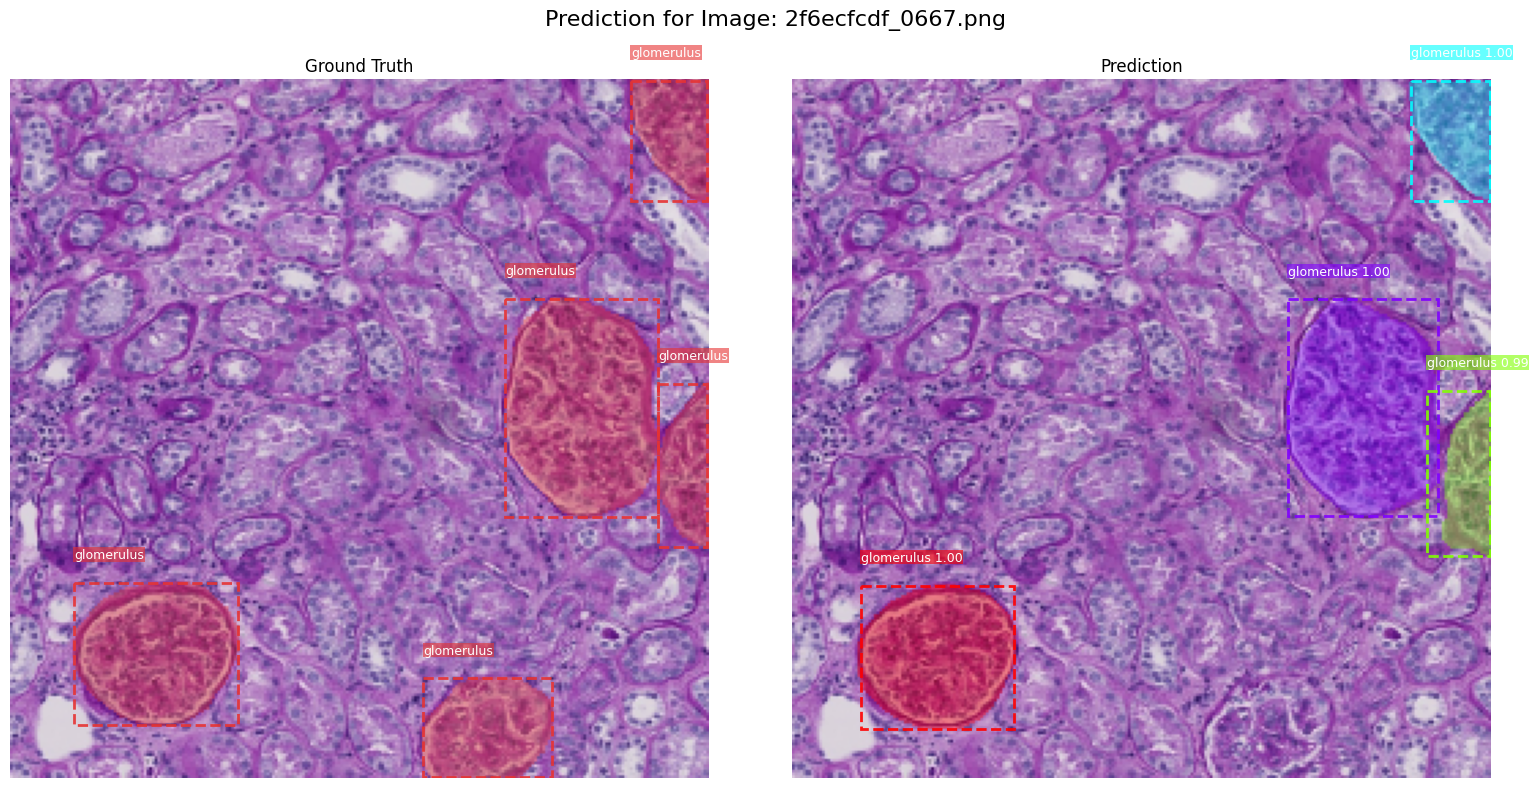


--- Visualizing 5 RANDOM test predictions ---
Visualizing: 8242609fa_1199.png (Index: 124)


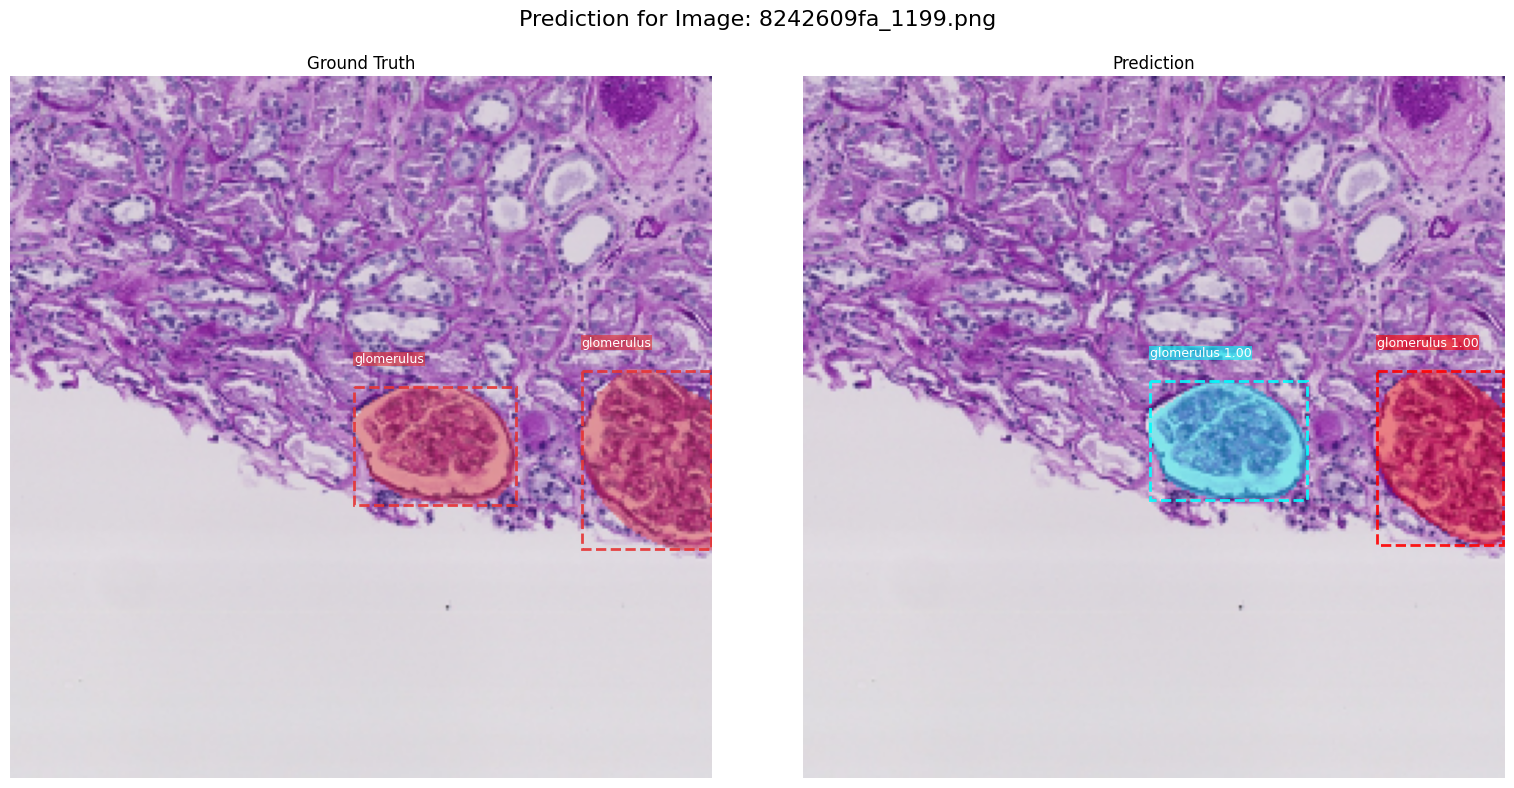

Visualizing: 8242609fa_0535.png (Index: 106)


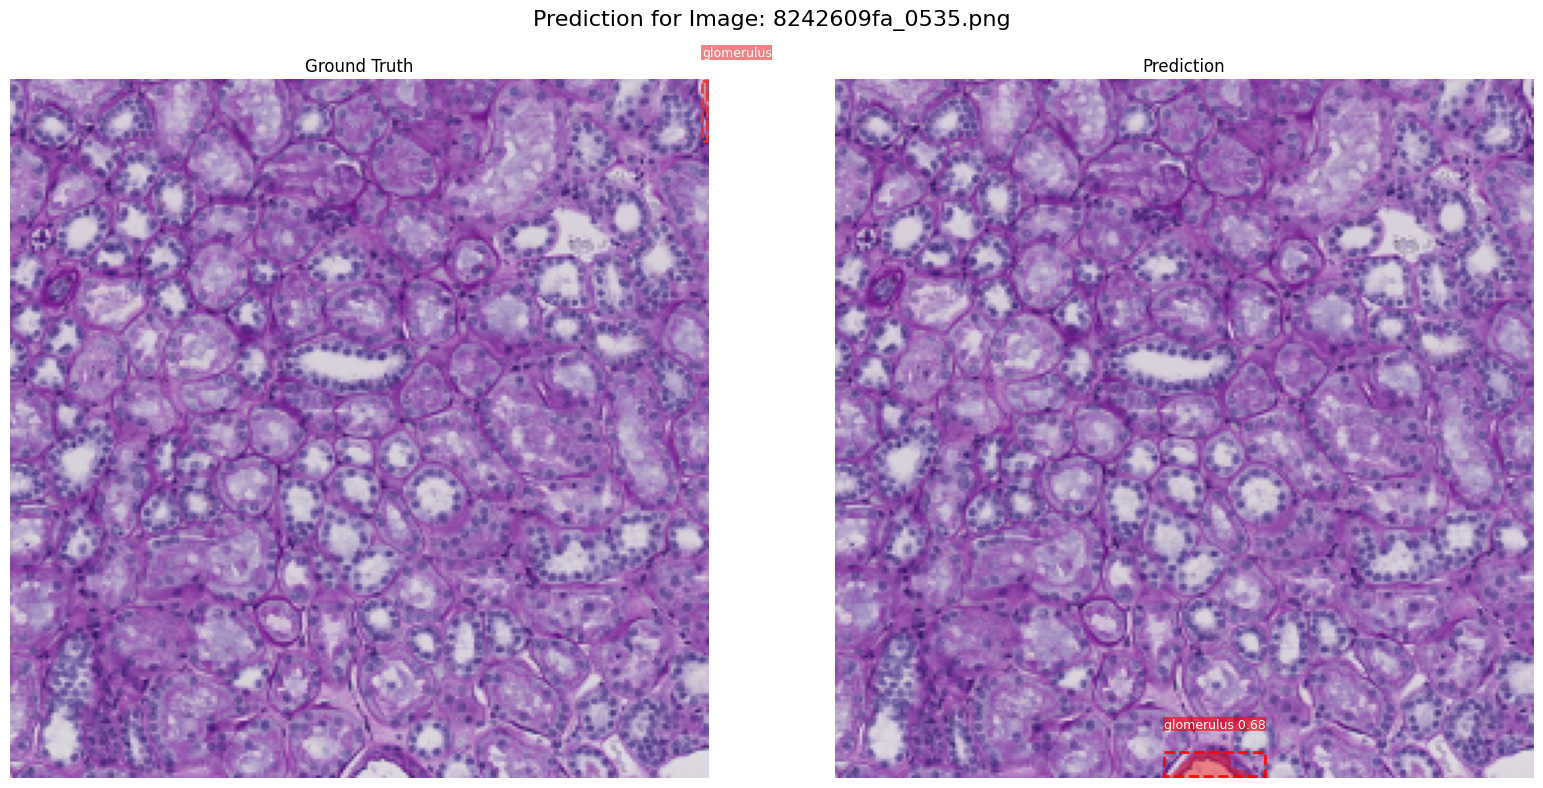

Visualizing: cb2d976f4_0695.png (Index: 177)


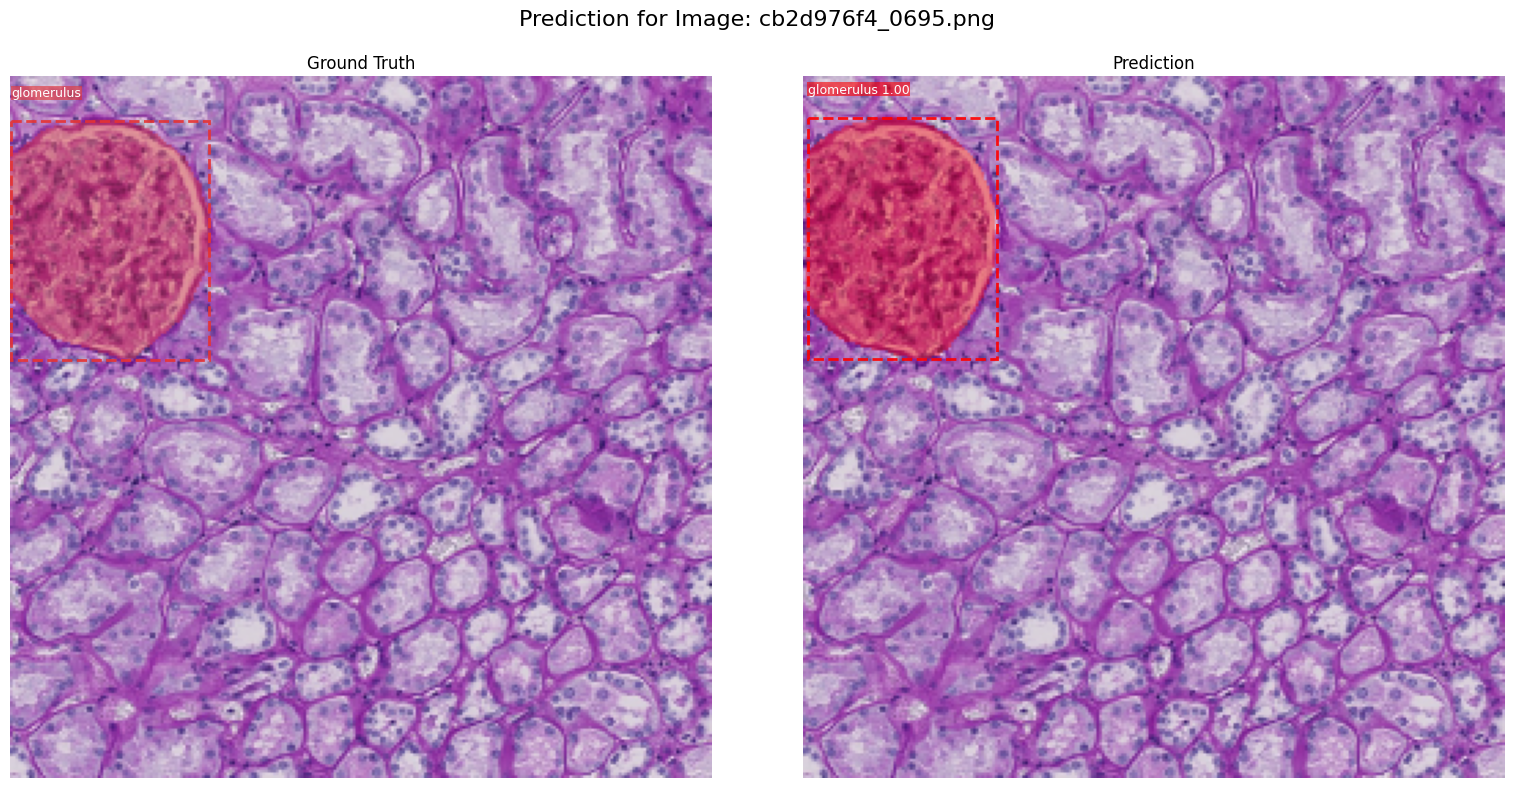

Visualizing: 1e2425f28_0583.png (Index: 37)


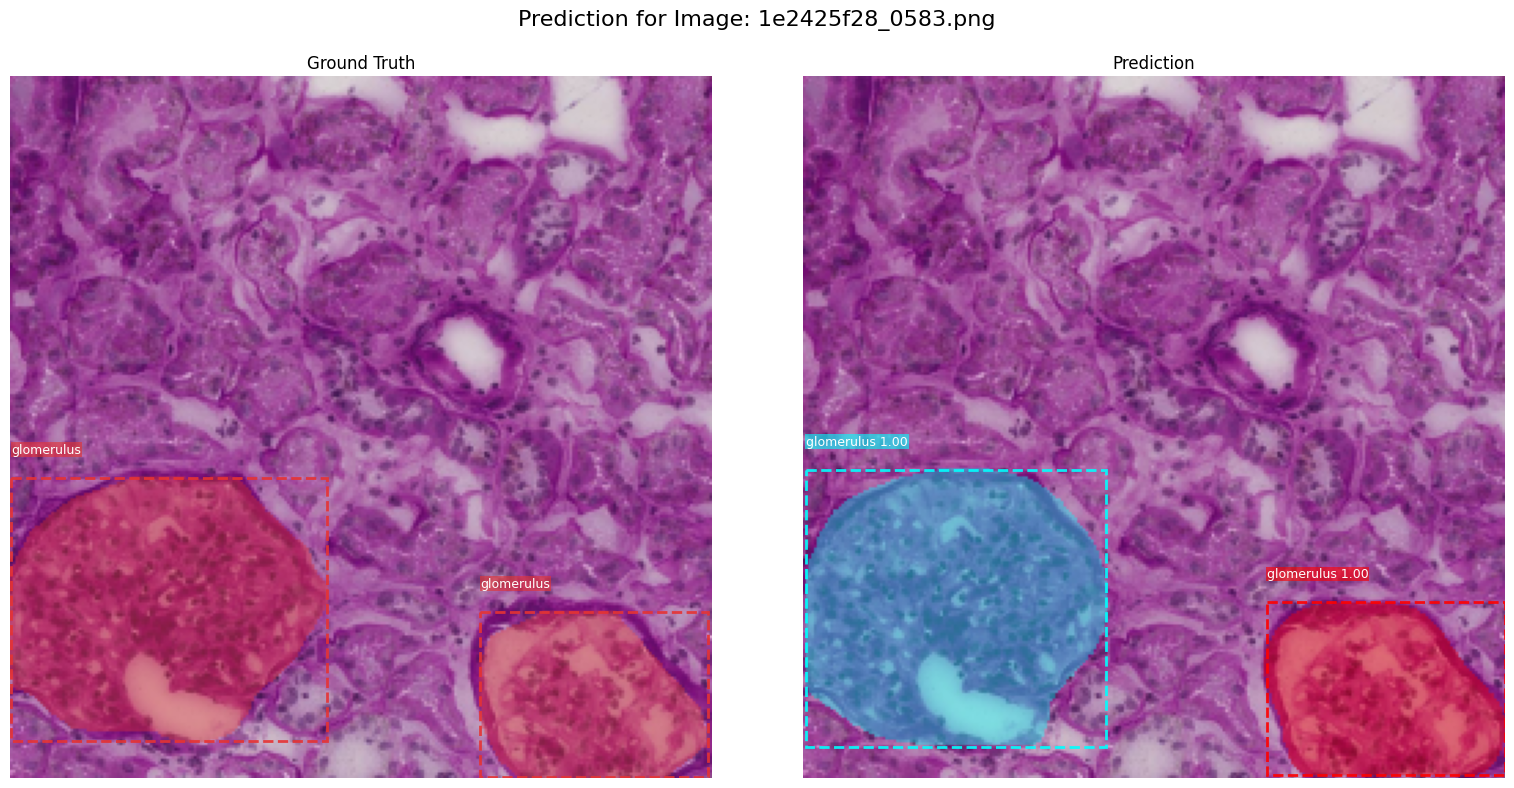

Visualizing: b9a3865fc_1090.png (Index: 163)


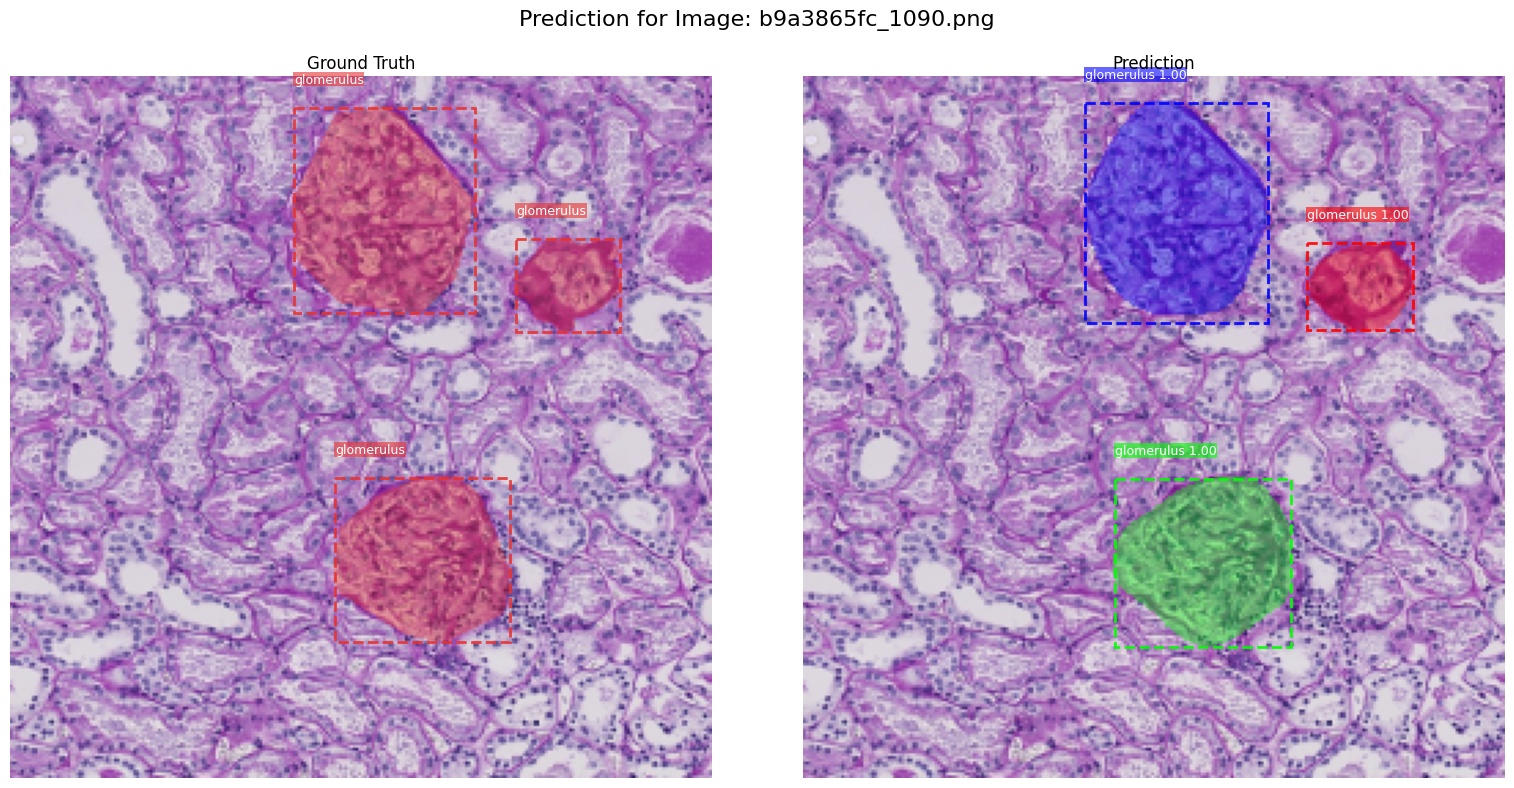

In [11]:
# Cell 2 (Modified): Visualize Predictions 

# Ensure these variables are defined from previous cells:
# test_dataset: Your loaded GlomeruliDataset for Mask R-CNN. 
#               This dataset class MUST have an attribute like 'self.image_files'
#               which stores a list of image basenames (e.g., ["image1.png", "image2.png", ...]).
# model: Your trained and loaded Mask R-CNN model, set to eval mode.
# DEVICE: Your torch.device.
# visualize_gt_pred_comparison: The function that actually draws the plots, assumed to be defined.

# Define class names (if not already available as a dataset attribute)
# This list's indices should correspond to the class IDs predicted by the model.
# For Mask R-CNN, class ID 0 is usually background.
dataset_class_names = ['background', 'glomerulus'] # Assuming 'glomerulus' is class ID 1

# --- 1. Visualize a SPECIFIC image by its FILENAME ---
# Replace "your_target_image_filename.png" with the actual filename you want to visualize
# This filename should exist in your test_dataset.image_files list.
specific_image_filename_to_show = "2f6ecfcdf_0667.png" # <<< CHANGE THIS to your desired filename

if 'test_dataset' in locals() and len(test_dataset) > 0:
    visualize_specific_image_by_filename(
        image_filename=specific_image_filename_to_show, # Pass the filename string
        dataset=test_dataset,
        model=model,
        device=DEVICE,
        class_names=dataset_class_names,
        score_thresh=0.3 # You can adjust this score threshold for display
    )
elif 'test_dataset' not in locals():
    print("Error: 'test_dataset' is not defined. Please ensure it has been created.")
else: # test_dataset is empty
    print("Test dataset is empty, cannot visualize specific image by filename.")


# --- (Optional) Keep visualization by INDEX if you still need it ---
# specific_image_index_to_show = 18 
# if 'test_dataset' in locals() and len(test_dataset) > 0:
#     visualize_specific_image_by_index(
#         specific_idx=specific_image_index_to_show,
#         dataset=test_dataset,
#         model=model,
#         device=DEVICE,
#         class_names=dataset_class_names,
#         score_thresh=0.3
#     )
# else:
#     # Handling for index visualization
#     pass


# --- 2. Then, visualize a few RANDOM images (this part remains the same) ---
number_of_random_images_to_show = 5 # You can change this number

if 'test_dataset' in locals() and len(test_dataset) > 0:
    visualize_random_selected_images(
        num_to_show=number_of_random_images_to_show,
        dataset=test_dataset,
        model=model,
        device=DEVICE,
        class_names=dataset_class_names,
        score_thresh=0.3 # You can adjust this score threshold for display
    )
elif 'test_dataset' not in locals():
    print("Error: 'test_dataset' is not defined. Cannot visualize random images.")
else: # test_dataset is empty
    print("Test dataset is empty, cannot visualize random images.")